In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from data import prepare_train_test_data, OBS_VAR_NAMES, ENDO_NAMES
from models import *
from visualize import plot_preds

In [3]:
N_TRAINSTEPS = 230 # 00
N_LAG = 4

y_hats = {}

## Smets-Wouters

In [4]:
from data import read_smets_wouters_prediction
sw_preds = read_smets_wouters_prediction()[:10,:7,:230]
idxs = [np.where(np.array(list(ENDO_NAMES))==x)[0][0] for x in OBS_VAR_NAMES]
sw_preds = sw_preds[:,idxs].transpose(2,0,1)
train_sw_preds, test_sw_preds = sw_preds[:N_TRAINSTEPS], sw_preds[N_TRAINSTEPS:]
# y_hats['SW'] = test_sw_preds[4:-5]
y_hats['SW'] = sw_preds[4:-11]#5]

## VAR

In [5]:
N_SW_FORWARD = 0
SW_PARAMS = []

In [6]:
from data import read_smets_wouters_observations

sw_obs = read_smets_wouters_observations()
# train_sw_obs, test_sw_obs = sw_obs[:N_TRAINSTEPS], sw_obs[N_TRAINSTEPS:]
model = VAR(n_lag=N_LAG, n_sw_forward=N_SW_FORWARD, sw_params=SW_PARAMS)
model.fit(inputs=sw_obs, targets=None)

In [7]:
y_hat_test = model.estimate(sw_obs, n_timesteps=10)
y_hats['VAR'] = y_hat_test[:-11]#5]

## NonLin NN Torch Backprop

In [8]:
N_SW_FORWARD = 4
SW_PARAMS = OBS_VAR_NAMES

In [9]:
(train_inputs, test_inputs), (train_targets, test_targets) = prepare_train_test_data(
    n_trainsteps=N_TRAINSTEPS,
    n_lag=N_LAG,
    n_sw_forward=N_SW_FORWARD,
    sw_params=SW_PARAMS
)
test_inputs = train_inputs
test_targets = train_targets

In [10]:
model = NonLinearNN_torch_backprop(n_lag=N_LAG, n_sw_forward=N_SW_FORWARD, sw_params=SW_PARAMS)
model.fit(train_inputs, train_targets)


In [11]:
y_hat_test = model.estimate(test_inputs, n_timesteps=10)
y_hats['NN SW BP'] = y_hat_test

## NonLin NN Torch LBFGS wo SW

In [12]:
N_TRAINSTEPS = 230
N_LAG = 4
N_SW_FORWARD = 0
SW_PARAMS = []

In [13]:
(train_inputs, test_inputs), (train_targets, test_targets) = prepare_train_test_data(
    n_trainsteps=N_TRAINSTEPS,
    n_lag=N_LAG,
    n_sw_forward=N_SW_FORWARD,
    sw_params=SW_PARAMS
)
test_inputs = train_inputs
test_targets = train_targets

In [14]:
model = NonLinearNN_torch_lbfgs(n_lag=N_LAG, n_sw_forward=N_SW_FORWARD, sw_params=SW_PARAMS)
model.fit(train_inputs, train_targets)

Sequential(
  (0): Linear(in_features=28, out_features=40, bias=True)
  (1): Tanh()
  (2): Dropout1d(p=0.1, inplace=False)
  (3): Linear(in_features=40, out_features=7, bias=True)
)


In [15]:
y_hat_test = model.estimate(test_inputs, n_timesteps=10)
y_hats['NN'] = y_hat_test

## NonLin NN Torch LBFGS w SW

In [16]:
N_SW_FORWARD = 4
SW_PARAMS = OBS_VAR_NAMES

In [17]:
(train_inputs, test_inputs), (train_targets, test_targets) = prepare_train_test_data(
    n_trainsteps=N_TRAINSTEPS,
    n_lag=N_LAG,
    n_sw_forward=N_SW_FORWARD,
    sw_params=SW_PARAMS
)
test_inputs = train_inputs
test_targets = train_targets

In [18]:
model = NonLinearNN_torch_lbfgs(n_lag=N_LAG, n_sw_forward=N_SW_FORWARD, sw_params=SW_PARAMS)
model.fit(train_inputs, train_targets)

Sequential(
  (0): Linear(in_features=56, out_features=40, bias=True)
  (1): Tanh()
  (2): Dropout1d(p=0.1, inplace=False)
  (3): Linear(in_features=40, out_features=7, bias=True)
)


In [19]:
y_hat_test = model.estimate(test_inputs, n_timesteps=10)
y_hats['NN SW'] = y_hat_test

## Visualize

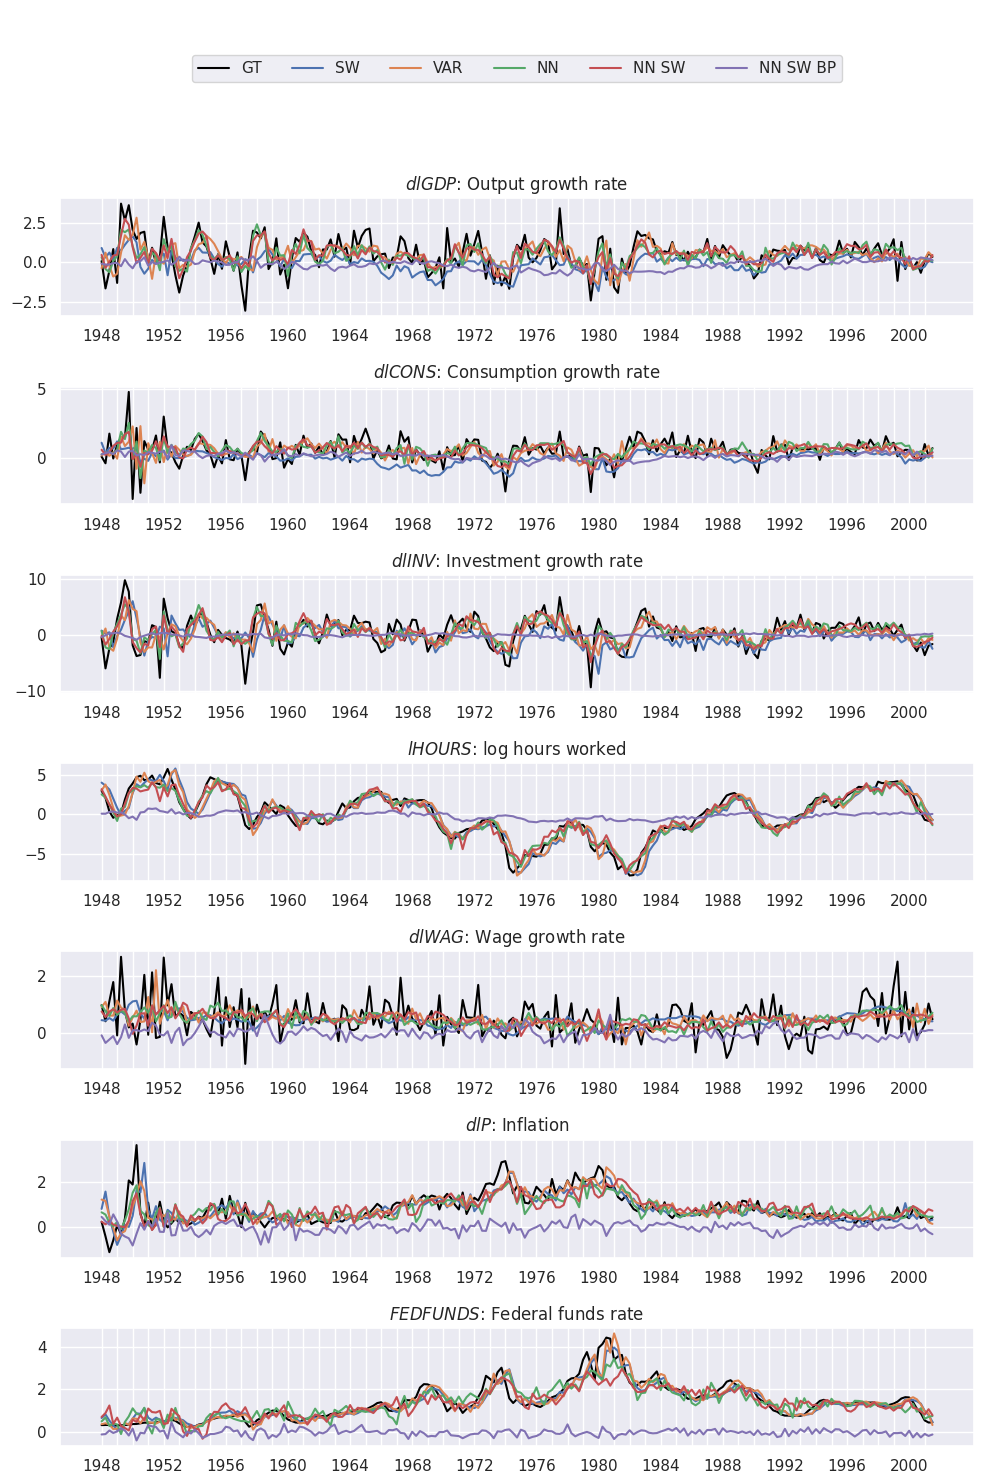

In [20]:
order = ['SW', 'VAR', 'NN', 'NN SW', 'NN SW BP']
y_hats = {k: y_hats[k] for k in order}
n_timestep_forecast = 1
fig = plot_preds(test_targets, y_hats, n_timestep_forecast=n_timestep_forecast)
fig.savefig(f'images/forecast_{n_timestep_forecast}.pdf', bbox_inches='tight')

In [21]:
from utils import rsmes_per_method

rmse_df = rsmes_per_method(test_targets, {k:v for k,v in y_hats.items() if 'BP' not in k})

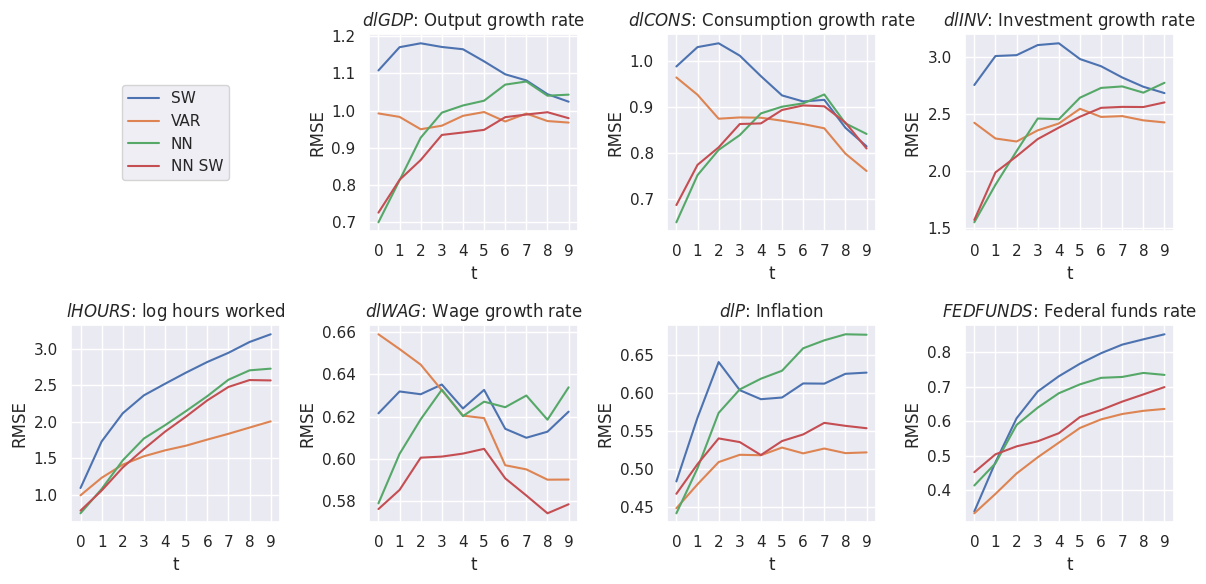

In [22]:
from visualize import plot_rmses

fig = plot_rmses(data=rmse_df)
fig.savefig('images/rmses_sym_t.pdf', bbox_inches='tight')

In [23]:
mean_rmse_per_method = rmse_df.groupby('method').mean().round(3)[OBS_VAR_NAMES]
# mean_rmse_per_method['mean'] = (mean_rmse_per_method / mean_rmse_per_method.max(0)).mean(axis=1)
mean_rmse_per_method

,dy,dc,dinve,labobs,dw,pinfobs,robs
method,,,,,,,
NN,0.971,0.837,2.411,1.950,0.619,0.605,0.643
NN SW,0.918,0.837,2.312,1.866,0.590,0.532,0.586
SW,1.118,0.946,2.918,2.453,0.624,0.596,0.691
VAR,0.977,0.866,2.413,1.594,0.620,0.509,0.527


In [24]:
mean_rmse_per_method.to_latex()

'\\begin{tabular}{lrrrrrrr}\n\\toprule\n & dy & dc & dinve & labobs & dw & pinfobs & robs \\\\\nmethod &  &  &  &  &  &  &  \\\\\n\\midrule\nNN & 0.971000 & 0.837000 & 2.411000 & 1.950000 & 0.619000 & 0.605000 & 0.643000 \\\\\nNN SW & 0.918000 & 0.837000 & 2.312000 & 1.866000 & 0.590000 & 0.532000 & 0.586000 \\\\\nSW & 1.118000 & 0.946000 & 2.918000 & 2.453000 & 0.624000 & 0.596000 & 0.691000 \\\\\nVAR & 0.977000 & 0.866000 & 2.413000 & 1.594000 & 0.620000 & 0.509000 & 0.527000 \\\\\n\\bottomrule\n\\end{tabular}\n'

## P Values

In [25]:
from utils import paired_sample_t_test

In [26]:
methods = list(y_hats)
p_values = []
for m1 in methods:
    for m2 in methods:
        for timestep in range(4):
            for i, var_name in enumerate(OBS_VAR_NAMES):
                s1 = y_hats[m1][:,timestep,i]
                s2 = y_hats[m2][:,timestep,i]
                s1 = (s1-test_targets[timestep:len(s1)+timestep,i])**2
                s2 = (s2-test_targets[timestep:len(s2)+timestep,i])**2
                p_value = paired_sample_t_test(s1, s2)
                p_values.append({
                    'm1': m1, 'm2': m2, 't': timestep, 'obs': var_name, 'p': p_value
                })
p_values = pd.DataFrame(p_values)

In [27]:
VAR_NAME = 'robs'
T = 0

_df = p_values[(p_values.obs==VAR_NAME)&(p_values.t==T)]
reshaped_data = []
for m1 in methods[:-2]:
    m1_p_values = {}
    for m2 in methods[1:-1]:
        m1_p_values[m2] = _df[(_df.m1==m1)&(_df.m2==m2)].p.item()
    reshaped_data.append(m1_p_values)
ps = pd.DataFrame(reshaped_data, columns=methods[1:-1], index=methods[:-2])
ps

,VAR,NN,NN SW
SW,0.698,0.000,0.004
VAR,NaN,0.001,0.004
NN,0.001,NaN,0.163


In [28]:
ps.to_latex()

'\\begin{tabular}{lrrr}\n\\toprule\n & VAR & NN & NN SW \\\\\n\\midrule\nSW & 0.698000 & 0.000000 & 0.004000 \\\\\nVAR & NaN & 0.001000 & 0.004000 \\\\\nNN & 0.001000 & NaN & 0.163000 \\\\\n\\bottomrule\n\\end{tabular}\n'

## SHAP Values

In [29]:
import shap

def calculate_shap_values(model, inputs):
    explainer = shap.DeepExplainer(model, inputs)
    shap_values = explainer.shap_values(inputs)
    return shap_values

In [30]:
shap_values = calculate_shap_values(model.model, torch.tensor(train_inputs).float())

/mnt/ssd/anaconda3/envs/econ/lib/python3.11/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: Dropout1d
  warnings.warn(f'unrecognized nn.Module: {module_type}')


In [31]:
shap_values.shape
shaps = []
for t in range(shap_values.shape[0]):
    for v in range(shap_values.shape[1]):
        for i, obs_name in enumerate(OBS_VAR_NAMES):
            shaps.append({'T': t, 'V': v, 'OBS': obs_name, 'SHAP': shap_values[t,v,i]})
shaps = pd.DataFrame(shaps)
shaps

,T,V,OBS,SHAP
0,0,0,dy,0.019510
1,0,0,dc,0.025935
2,0,0,dinve,0.018419
3,0,0,labobs,0.028509
4,0,0,dw,-0.011108
...,...,...,...,...
88195,224,55,dinve,0.007088
88196,224,55,labobs,-0.000175
88197,224,55,dw,0.000369
88198,224,55,pinfobs,-0.000808


In [32]:
from data import OBS_VAR_NAMES
n_lag = 4
n_sw_forward = 4
var_names = []
for i, o in enumerate(OBS_VAR_NAMES):
    o = ENDO_NAMES[o]['tex']
    for l in range(n_lag):
        var_names.append(f"{o[:-1]}_{{t-{l+1}}}$")
for i, o in enumerate(OBS_VAR_NAMES):
    o = ENDO_NAMES[o]['tex']
    for l in range(n_sw_forward):
        if l == 0:
            var_names.append(f"{o[:-1]}_{{SW,t}}$")
        else:
            var_names.append(f"{o[:-1]}_{{SW,(t+{l})}}$")

In [33]:
for o in shaps.OBS.unique():
    shaps.replace(o, ENDO_NAMES[o]['tex'], inplace=True)

In [34]:
shaps

,T,V,OBS,SHAP
0,0,0,${dlGDP}$,0.019510
1,0,0,${dlCONS}$,0.025935
2,0,0,${dlINV}$,0.018419
3,0,0,${lHOURS}$,0.028509
4,0,0,${dlWAG}$,-0.011108
...,...,...,...,...
88195,224,55,${dlINV}$,0.007088
88196,224,55,${lHOURS}$,-0.000175
88197,224,55,${dlWAG}$,0.000369
88198,224,55,${dlP}$,-0.000808


/tmp/ipykernel_2061251/1404372862.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(var_names[low:high], rotation=90)
/tmp/ipykernel_2061251/1404372862.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(var_names[low:high], rotation=90)
/tmp/ipykernel_2061251/1404372862.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(var_names[low:high], rotation=90)
/tmp/ipykernel_2061251/1404372862.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(var_names[low:high], rotation=90)
/tmp/ipykernel_2061251/1404372862.py:41: UserWarning: set_ticklabels() should only be us

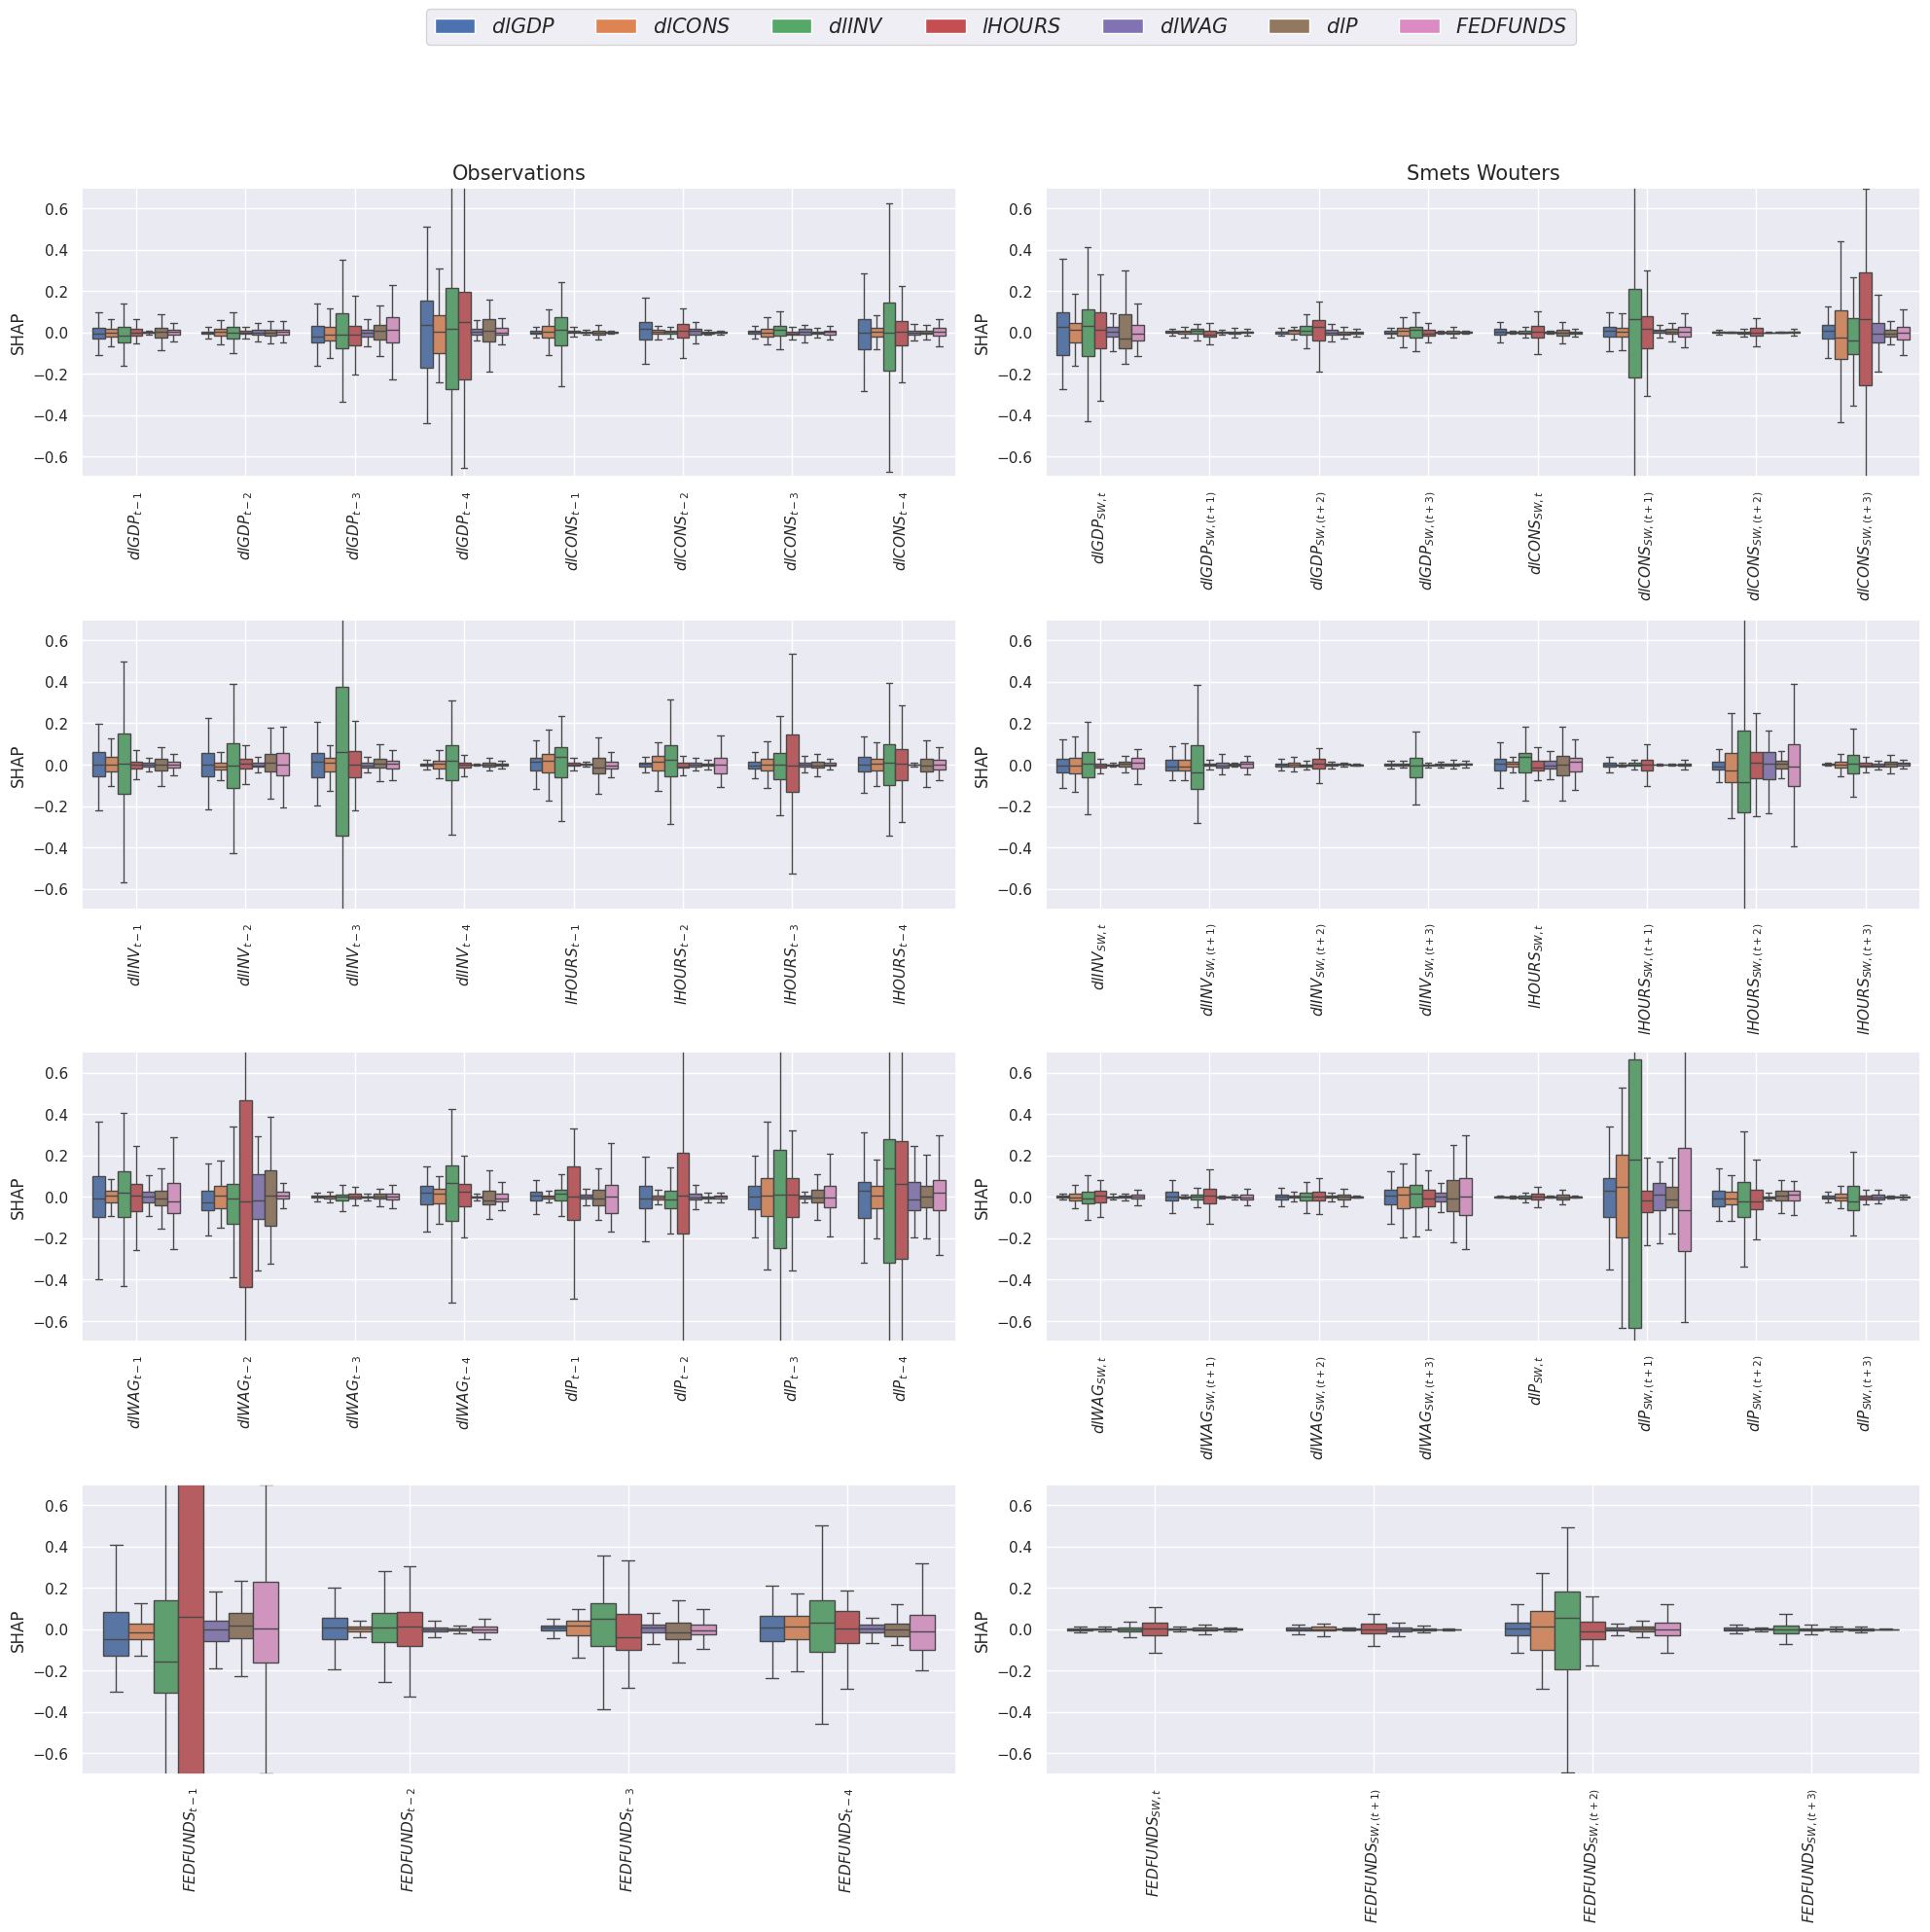

In [35]:
import seaborn as sns
import matplotlib.gridspec as gridspec

# fig,axs = plt.subplots(3,1,figsize=(20,9))
fig = plt.figure(figsize=(20,20))

gs = gridspec.GridSpec(5,2, height_ratios=[.1, 2, 2, 2, 2]) 

# ax = axs[0]
ax = fig.add_subplot(gs[0,:])
cp = sns.color_palette()
for i, o in enumerate(OBS_VAR_NAMES):
    o = ENDO_NAMES[o]['tex']
    ax.bar([0],[1],label=o,color=cp[i])
ax.legend(ncol=len(OBS_VAR_NAMES), loc='lower center', bbox_to_anchor=(0.5, -0.7), fontsize=15)
ax.set_axis_off()
ax.set_ylim([2,3])

for i in range(4):
# ax = axs[1]
    low, high = i*8, (i+1)*8
    high = min(high, 28)
    ax = fig.add_subplot(gs[i+1,0])
    sns.boxplot(data=shaps[(shaps.V<high) & (shaps.V>=low)], x='V', y='SHAP', hue='OBS',ax=ax, showfliers=False)
    ax.set_ylim([-0.7,0.7])
    _ = ax.set_xticklabels(var_names[low:high], rotation=90)
    ax.set_xlabel(None)
    ax.set_ylabel('SHAP')
    ax.get_legend().remove()
    ax.grid(True,axis='x')
    if i == 0:
        ax.set_title('Observations', fontsize=15)

for i in range(4):
# ax = axs[1]
    low, high = i*8+28, (i+1)*8+28
    # high = min(high, 56)
    ax = fig.add_subplot(gs[i+1,1])
    sns.boxplot(data=shaps[(shaps.V<high) & (shaps.V>=low)], x='V', y='SHAP', hue='OBS',ax=ax, showfliers=False)
    ax.set_ylim([-0.7,0.7])
    _ = ax.set_xticklabels(var_names[low:high], rotation=90)
    ax.set_xlabel(None)
    ax.set_ylabel('SHAP')
    ax.get_legend().remove()
    ax.grid(True,axis='x')
    if i == 0:
        ax.set_title('Smets Wouters', fontsize=15)

fig.tight_layout()
plt.savefig('images/shaps3.pdf', bbox_inches='tight')

In [36]:
from data import ENDO_NAMES

shaps_per_obs95 = shaps.groupby(['OBS','V']).SHAP.apply(lambda x: np.percentile(x,95))
shaps_per_obs95 = shaps_per_obs95.reset_index().groupby('OBS').apply(lambda x: x.nlargest(5, 'SHAP').round(3))
shaps_per_obs95 = shaps_per_obs95[['V','SHAP']].reset_index().drop(columns=['level_1'])
shaps_per_obs95['feature'] = shaps_per_obs95.V.apply(lambda x: var_names[x])
shaps_per_obs95 = shaps_per_obs95[['OBS','feature','SHAP']]
shaps_per_obs95 = shaps_per_obs95.rename(columns={'feature': 'feature95', 'SHAP': 'SHAP95'})

shaps_per_obs05 = shaps.groupby(['OBS','V']).SHAP.apply(lambda x: np.percentile(x,5))
shaps_per_obs05 = shaps_per_obs05.reset_index().groupby('OBS').apply(lambda x: x.nsmallest(5, 'SHAP').round(3))
shaps_per_obs05 = shaps_per_obs05[['V','SHAP']].reset_index().drop(columns=['level_1'])
shaps_per_obs05['feature'] = shaps_per_obs05.V.apply(lambda x: var_names[x])
shaps_per_obs05 = shaps_per_obs05[['OBS','feature','SHAP']]
shaps_per_obs05 = shaps_per_obs05.rename(columns={'feature': 'feature05', 'SHAP': 'SHAP05'})

shaps_per_obs = pd.concat([shaps_per_obs95, shaps_per_obs05[['feature05','SHAP05']]],axis=1)
# shaps_per_obs['OBS'] = shaps_per_obs.OBS.apply(lambda x: ENDO_NAMES[x]['tex'])
shaps_per_obs

/tmp/ipykernel_2061251/4206378093.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shaps_per_obs95 = shaps_per_obs95.reset_index().groupby('OBS').apply(lambda x: x.nlargest(5, 'SHAP').round(3))
/tmp/ipykernel_2061251/4206378093.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shaps_per_obs05 = shaps_per_obs05.reset_index().groupby('OBS').apply(lambda x: x.nsmallest(5, 'SHAP').round(3))


,OBS,feature95,SHAP95,feature05,SHAP05
0,${FEDFUNDS}$,"${dlP}_{SW,(t+1)}$",0.590,${FEDFUNDS}_{t-1}$,-0.540
1,${FEDFUNDS}$,${FEDFUNDS}_{t-1}$,0.423,"${dlP}_{SW,(t+1)}$",-0.463
2,${FEDFUNDS}$,"${lHOURS}_{SW,(t+2)}$",0.246,${dlP}_{t-4}$,-0.280
3,${FEDFUNDS}$,${FEDFUNDS}_{t-4}$,0.220,"${lHOURS}_{SW,(t+2)}$",-0.234
4,${FEDFUNDS}$,${dlWAG}_{t-1}$,0.210,"${dlWAG}_{SW,(t+3)}$",-0.209
5,${dlCONS}$,"${dlCONS}_{SW,(t+3)}$",0.414,"${dlP}_{SW,(t+1)}$",-0.495
6,${dlCONS}$,"${dlP}_{SW,(t+1)}$",0.351,"${dlCONS}_{SW,(t+3)}$",-0.286
7,${dlCONS}$,"${lHOURS}_{SW,(t+2)}$",0.246,${dlP}_{t-3}$,-0.212
8,${dlCONS}$,${dlP}_{t-3}$,0.222,"${FEDFUNDS}_{SW,(t+2)}$",-0.207
9,${dlCONS}$,"${FEDFUNDS}_{SW,(t+2)}$",0.191,${FEDFUNDS}_{t-4}$,-0.182


In [37]:
for row in shaps_per_obs.to_latex().split('\\\n'):
    print(row + '\\')

\begin{tabular}{lllrlr}
\toprule
 & OBS & feature95 & SHAP95 & feature05 & SHAP05 \\
\midrule
0 & ${FEDFUNDS}$ & ${dlP}_{SW,(t+1)}$ & 0.590000 & ${FEDFUNDS}_{t-1}$ & -0.540000 \\
1 & ${FEDFUNDS}$ & ${FEDFUNDS}_{t-1}$ & 0.423000 & ${dlP}_{SW,(t+1)}$ & -0.463000 \\
2 & ${FEDFUNDS}$ & ${lHOURS}_{SW,(t+2)}$ & 0.246000 & ${dlP}_{t-4}$ & -0.280000 \\
3 & ${FEDFUNDS}$ & ${FEDFUNDS}_{t-4}$ & 0.220000 & ${lHOURS}_{SW,(t+2)}$ & -0.234000 \\
4 & ${FEDFUNDS}$ & ${dlWAG}_{t-1}$ & 0.210000 & ${dlWAG}_{SW,(t+3)}$ & -0.209000 \\
5 & ${dlCONS}$ & ${dlCONS}_{SW,(t+3)}$ & 0.414000 & ${dlP}_{SW,(t+1)}$ & -0.495000 \\
6 & ${dlCONS}$ & ${dlP}_{SW,(t+1)}$ & 0.351000 & ${dlCONS}_{SW,(t+3)}$ & -0.286000 \\
7 & ${dlCONS}$ & ${lHOURS}_{SW,(t+2)}$ & 0.246000 & ${dlP}_{t-3}$ & -0.212000 \\
8 & ${dlCONS}$ & ${dlP}_{t-3}$ & 0.222000 & ${FEDFUNDS}_{SW,(t+2)}$ & -0.207000 \\
9 & ${dlCONS}$ & ${FEDFUNDS}_{SW,(t+2)}$ & 0.191000 & ${FEDFUNDS}_{t-4}$ & -0.182000 \\
10 & ${dlGDP}$ & ${FEDFUNDS}_{t-1}$ & 0.380000 & ${dlGDP}